In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

import sys
sys.path.append("lib")

import lib

import torch
torch.set_default_dtype(torch.float64)

from functorch import vmap
from torch.utils.data import DataLoader
import tqdm

/home/peiyi/mambaforge3/envs/rom/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

In [3]:
coords_x, coords_y, _ = lib.utils.read_coords("2d_burger_data/time_step_0.csv")
coords = torch.stack((coords_x, coords_y), dim=1)

In [4]:
num_steps = 501
num_nodes = coords_x.shape[0]

datas = lib.utils.read_data(num_steps, num_nodes, '2d_burger_data/time_step_', 'vel_0')
datas.shape

torch.Size([501, 14641])

In [5]:
N = datas.shape[1]
n = 20
mu = int(np.ceil(N/20))
neighbours = lib.utils.topk_neighbours(coords, mu)

In [6]:
batch_size = 2
train_data = DataLoader(datas, batch_size=batch_size, shuffle=True)

In [7]:
ed = lib.nrbs_n_N.EncoderDecoder(N=N, n=n, mu=mu, neighbours=neighbours, device=device)

In [8]:
# encoded = ed.nrbs.encode(datas[:2].to(device))
# encoded.shape

In [9]:
# a = ed.nrbs.decode(encoded)

In [10]:
# a.shape

In [11]:
ed.train(train_data_loader=train_data, epochs=1)

  0%|          | 1/251 [00:50<3:31:41, 50.80s/it]


KeyboardInterrupt: 

In [ ]:
approximates = ed(datas[499:501].to(device))
approximates[1].shape

torch.Size([14641])

In [ ]:
approximates[1]

tensor([ 1.0015e-04,  9.5711e-05,  9.6315e-05,  ..., -8.6603e-06,
        -2.1248e-05, -1.6884e-05], device='cuda:0', grad_fn=<SelectBackward0>)

In [ ]:
datas[500]

tensor([1.3673e-02, 1.3859e-02, 1.4044e-02,  ..., 6.5629e-31, 6.5629e-31,
        9.4247e-31])

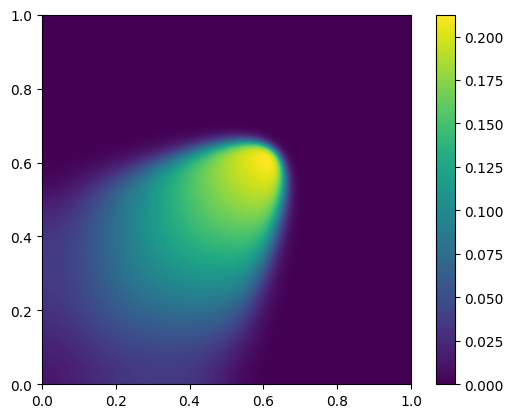

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = datas[500].tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

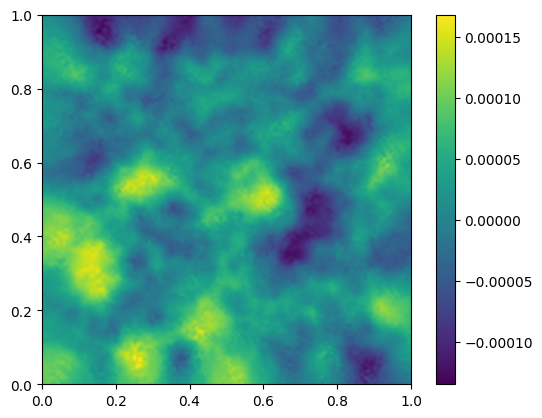

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# data coordinates and values
x = coords_x.tolist()
y = coords_y.tolist()
z = approximates[1].detach().cpu().tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()

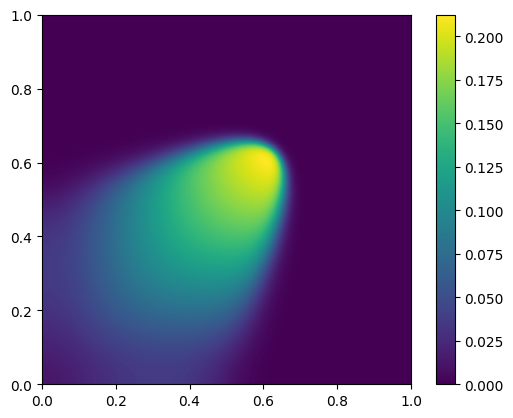

In [ ]:
err = abs(datas[500] - approximates[1].detach().cpu())

# data coordinates and values
z = err.tolist()

# target grid to interpolate to
xi = yi = np.linspace(0,1.0,1200)
xi,yi = np.meshgrid(xi,yi)

# set mask
# mask = (xi > 0.5) & (xi < 0.6) & (yi > 0.5) & (yi < 0.6)

# interpolate
zi = griddata((x,y),z,(xi,yi),method='cubic')

plt.imshow(zi,origin='lower', extent=[0,1,0,1])
plt.colorbar()